The type of problems that need recurrent processing<br>

1 - Generative Learning :- <br>

The principal idea is to use a sequence of known inputs to generate an output. By including the generated output to the known inputs, a sequence of infinite length can be generated.<br>
This type of Learning involves learning a model of the data distribution, allowing the generation of new data samples that are similar to the training data. You don't need to consume complete input, on the contrary just consume required finite length input, generate output, use that output as part of next sequence input and generate further. This is synchronous. E.g Predicting Next Character in a sentence/word. 

2- Sequence to Sequence:- <br>
Seq2Seq models differ from generative learning in the sense that inputs and outputs can be of different type and length. Whole input needs to be processed before moving towards output. It is asynchronous. E.g Translation from 1 language to another. 


Question For You :) <br>
Does ChatGPT fall under Generative Learning or a Sequence to Sequence  ? <br>
Hint:- ChatGPT generates text up to a maximum length specified by the user or the application. Alternatively, ChatGPT may generate text until it encounters a special end-of-sequence token. 

Jordan, Elman, and traditional RNNs (also known as vanilla RNNs) are all types of recurrent neural network architectures, but they differ in how they compute the hidden state and how they handle the flow of information through the network.<br>

Jordan RNN:<br>
In a Jordan RNN, the hidden state at time t is computed based on the current input and the previous output.<br>
Traditional RNN (Vanilla RNN):<br>
In a traditional RNN, the hidden state at time t is computed based on the current input and the previous hidden state, without any additional context.<br>
Elman RNN:<br>
In an Elman RNN, the hidden state at time t is computed based on the current input and the previous hidden state.<br>

Remember:-<br>
In recurrent neural networks (RNNs), including Elman RNNs and traditional RNNs, the hidden state is typically represented as a vector (or tensor) rather than a single variable.The hidden state ht at each time step t is a vector that captures the model's internal representation or "memory" of the input sequence up to that point in time. This vector contains multiple values, with each value representing different aspects or features of the input sequence.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [2]:
numberOftrainingPoints = 100
numberOfTestingPoints = 100

#Sinosidual Wave Formula Asin(2πft+ϕ)
freq = 4/150 # waves per N
timeLapse = np.linspace(start=0, stop=numberOftrainingPoints+numberOfTestingPoints,num=numberOftrainingPoints+numberOfTestingPoints)
SinosidualwaveData = np.sin(2*np.pi*freq*timeLapse)

'''
Shifting the output by one step in temporal machine learning, particularly in sequence prediction tasks,
is a common practice. This technique is known as "teacher forcing" in the context of sequence prediction models,
such as recurrent neural networks (RNNs) or autoregressive models.
'''

xTrain = SinosidualwaveData[:numberOftrainingPoints-1] # input
yTain = SinosidualwaveData[1:numberOftrainingPoints] # output (shifted by one step as generative model)

X_train = torch.Tensor(xTrain)
print(X_train.size())
y_train = torch.Tensor(yTain)
print(y_train.size())

torch.Size([99])
torch.Size([99])


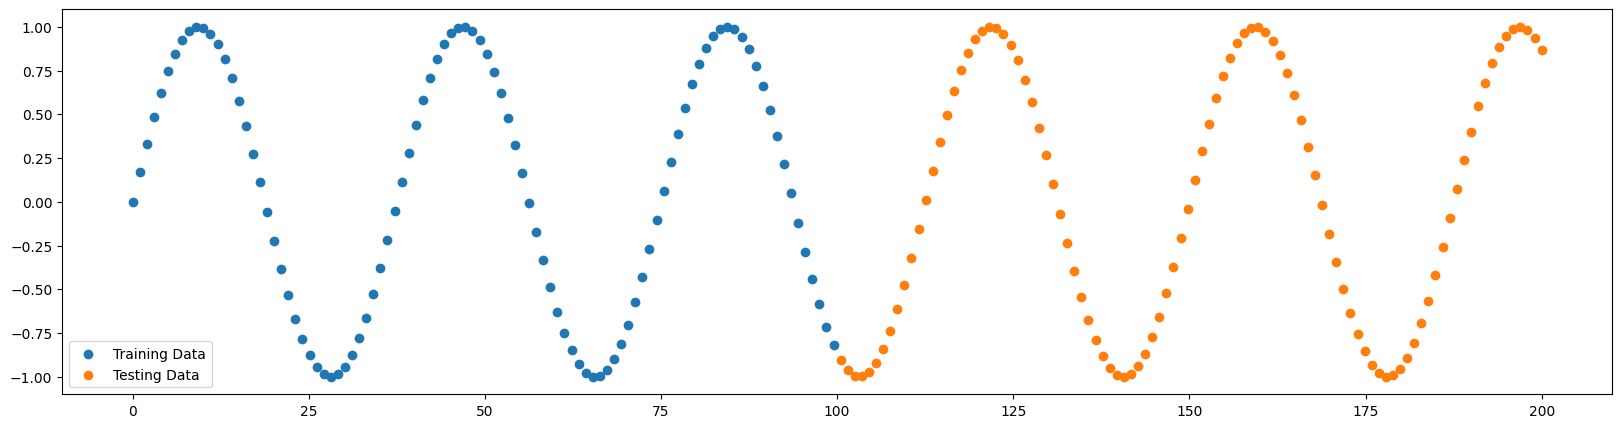

In [3]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(timeLapse[:numberOftrainingPoints],SinosidualwaveData[:numberOftrainingPoints],label="Training Data")
plt.scatter(timeLapse[numberOfTestingPoints:],SinosidualwaveData[numberOfTestingPoints:],label="Testing Data")
plt.legend()

In [10]:
#Building Single Block of RNN Not a Chain or a Model

class ElmanRNN(nn.Module):
    def __init__(self,hiddenStateVectorSize):
        super().__init__()
        
        '''nn.Parameter is a kind of Tensor that is to be considered a module parameter.requires_grad=True 
        mean use backbropagation for this parameter so it can learn and update its value.Putting it all together,
        Formula for a specific time t is :- 
        hidden state => ht = tanh(UXt + Wht-1 + b) #Here t-1 denotes last value of hidden state(context), b is bias
        New Output => yt = ActivationFunction(Vht + c)  # ht is calculated for this time t and c is bias 
        '''
        
        self.hiddenStateSize = hiddenStateVectorSize
        
        #This is the weight Matrix which will multiply with Previous Hidden State, It is not a vector , but a Matrix
        self.W = nn.Parameter(torch.randn(hiddenStateVectorSize,hiddenStateVectorSize),requires_grad=True)
        
        #U dimesions are decided as follows (hidden_size, input_size)
        #This is the weight Matrix which will multiply with Input, But in this specific case the input_size=1
        self.U = nn.Parameter(torch.randn(hiddenStateVectorSize,1),requires_grad=True)
        
        #This is a vector which will be added for hidden state
        self.b = nn.Parameter(torch.randn(hiddenStateVectorSize,1),requires_grad=True)
        
        #This is the weight Matrix which will multiply with New Hidden State, But in this specific case the input_size=1
        self.V = nn.Parameter(torch.randn(1,hiddenStateVectorSize),requires_grad=True)
        
        #This is a scalar value which will be added for the next output
        self.c = nn.Parameter(torch.randn(1),requires_grad=True)
        
        
    def forward(self, X , ht=None):
        outputs = []
        
        #As We are creating our own Elman RNN and lopping through Input We are going to create hidden state here instead of init
        #Remember At each epoch this forward is called once and whenever it is called we start with hidden state None
        if ht is None:
            #It will be a vector but not a nn.parameter as we are updating its value on our own.
            ht = torch.zeros(self.hiddenStateSize,1)
    
    
        #We Will process the Sequence Here Single Value by Value:    
        for particularTimeX in X:
            prev_ht = ht
            
            ht = torch.tanh(torch.mm(self.U,particularTimeX) + torch.mm(self.W,prev_ht) +  self.b)
            
            yt = torch.mm(self.V,ht) + self.c
            
            outputs.append(yt)
        
        #return torch.tensor(outputs,requires_grad=True), ht , Cna't use this as backpropagation isn't done by this
        
        #As each ouput element is a scalar so shape of 1,1 when use torch stack it becomes 99,1,1. We need this for evaluationg loss
        return torch.stack(outputs), ht
        

In [11]:
model = ElmanRNN(10)
print(model)

ElmanRNN()


In [12]:
learning_rate = 0.05
criterion = nn.MSELoss() # we are using means squered error as loss function here
optimizer = optim.Adam(model.parameters(), learning_rate)

### Training the Model

In [13]:
epochs = 1000 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    '''Making a Tensor of X_train Shape torch.Size([99, 1, 1]), instead of just passing it, so when it goes in forward and 
    each element is taken in for loop it is of shape [1,1] and can be multiplied with U Matrix of (hidden_size,1) '''
    output, ht = model(X_train.reshape(numberOftrainingPoints-1,1,-1))
    loss = criterion(output.reshape(-1), y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("Epoch {}: loss :{}".format(epoch, loss.item()))
        print("Hidden State a this Epoch Ht: ",ht.view(-1),"\n")

Epoch 0: loss :10.447611808776855
Hidden State a this Epoch Ht:  tensor([-0.1525,  0.9861, -0.1180,  0.9398, -0.8495,  0.9976, -0.2450,  0.9997,
        -0.9492, -0.8621], grad_fn=<ViewBackward0>) 

Epoch 100: loss :0.1359149068593979
Hidden State a this Epoch Ht:  tensor([ 1.0000,  1.0000, -0.9589,  0.5306, -0.9592,  0.7523,  0.9832,  0.9995,
        -0.9998,  0.9995], grad_fn=<ViewBackward0>) 

Epoch 200: loss :0.10315535962581635
Hidden State a this Epoch Ht:  tensor([ 0.7809,  0.9882, -0.1336,  0.3597, -0.9814, -0.9977, -0.2305,  0.9887,
        -1.0000,  0.9826], grad_fn=<ViewBackward0>) 

Epoch 300: loss :0.09979350119829178
Hidden State a this Epoch Ht:  tensor([ 0.8003,  0.9894, -0.1814,  0.3903, -0.9809, -0.9976, -0.2226,  0.9885,
        -1.0000,  0.9852], grad_fn=<ViewBackward0>) 

Epoch 400: loss :0.097706638276577
Hidden State a this Epoch Ht:  tensor([ 0.8239,  0.9902, -0.2063,  0.3912, -0.9807, -0.9975, -0.2100,  0.9882,
        -1.0000,  0.9866], grad_fn=<ViewBackward0>

##### Let's See How good the Model has learned Training Data 

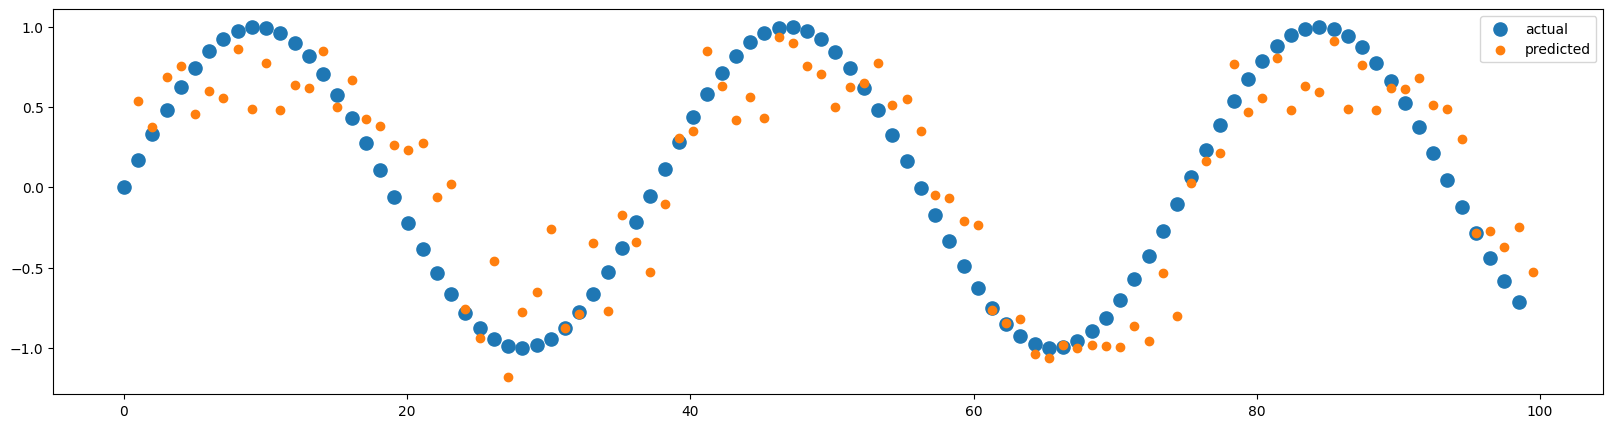

In [14]:
predictions = []
hidden_prev = None

# we will go over all points in out training sequence
for i in range(X_train.shape[0]):
    currentX = X_train[i]
    currentX = currentX.view(1, 1, 1)
    # we will give the current (single) point and the (current)
    # hidden state as input to our model
    
    # we carry over the previous hidden state
    pred, hidden_prev = model(currentX, hidden_prev)
    predictions.append(pred.item())

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(timeLapse[:numberOftrainingPoints-1], SinosidualwaveData[:numberOftrainingPoints-1], s=90, label='actual')
plt.scatter(timeLapse[1:numberOftrainingPoints], predictions, label='predicted')
ax.legend()

There are a mess, let Train them More. 

In [50]:
epochs = 4000 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    '''Making a Tensor of X_train Shape torch.Size([99, 1, 1]), instead of just passing it, so when it goes in forward and 
    each element is taken in for loop it is of shape [1,1] and can be multiplied with U Matrix of (hidden_size,1) '''
    output, ht = model(X_train.reshape(numberOftrainingPoints-1,1,-1))
    loss = criterion(output.reshape(-1), y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print("Epoch {}: loss :{}".format(epoch, loss.item()))
        print("Hidden State a this Epoch Ht: ",ht.view(-1),"\n")

Epoch 0: loss :0.0047083087265491486
Hidden State a this Epoch Ht:  tensor([ 1.0000,  0.2136,  0.9998, -0.9592, -0.9999, -0.9934, -0.9992,  0.9992,
         1.0000,  1.0000], grad_fn=<ViewBackward0>) 

Epoch 500: loss :0.0042068324983119965
Hidden State a this Epoch Ht:  tensor([ 1.0000,  0.1530,  0.9998, -0.9563, -0.9999, -0.9942, -0.9989,  0.9993,
         1.0000,  1.0000], grad_fn=<ViewBackward0>) 

Epoch 1000: loss :0.003546485910192132
Hidden State a this Epoch Ht:  tensor([ 1.0000,  0.0144,  0.9998, -0.9203, -0.9999, -0.9937, -0.9976,  0.9994,
         1.0000,  1.0000], grad_fn=<ViewBackward0>) 

Epoch 1500: loss :0.002863743342459202
Hidden State a this Epoch Ht:  tensor([ 1.0000, -0.1087,  0.9998, -0.8888, -0.9999, -0.9939, -0.9943,  0.9994,
         1.0000,  1.0000], grad_fn=<ViewBackward0>) 

Epoch 2000: loss :0.0024034453090280294
Hidden State a this Epoch Ht:  tensor([ 1.0000, -0.1890,  0.9998, -0.9067, -0.9999, -0.9949, -0.9885,  0.9994,
         1.0000,  1.0000], grad_fn=

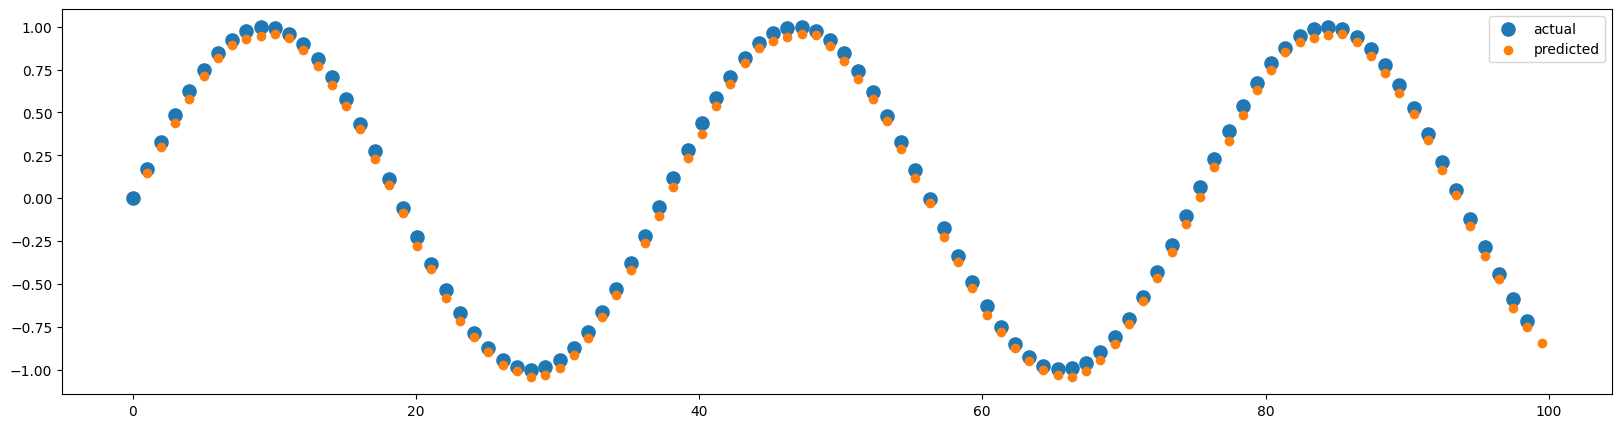

In [51]:
predictions = []
hidden_prev = None

# we will go over all points in out training sequence
for i in range(X_train.shape[0]):
    currentX = X_train[i]
    currentX = currentX.view(1, 1, 1)
    # we will give the current (single) point and the (current)
    # hidden state as input to our model
    
    # we carry over the previous hidden state
    pred, hidden_prev = model(currentX, hidden_prev)
    predictions.append(pred.item())

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(timeLapse[:numberOftrainingPoints-1], SinosidualwaveData[:numberOftrainingPoints-1], s=90, label='actual')
plt.scatter(timeLapse[1:numberOftrainingPoints], predictions, label='predicted')
ax.legend()

After 4000 epoch of more training It became alot better on training Data <br>
I would like to add sometimes you become lucky, As the random initialzation of the parameters in Elman RNN are so good you don't need more epochs of traning 

In [45]:
len(predictions)

99

#### Lets' s Validate model's ability to generate a longer sequence of data by re-feeding its own outputs

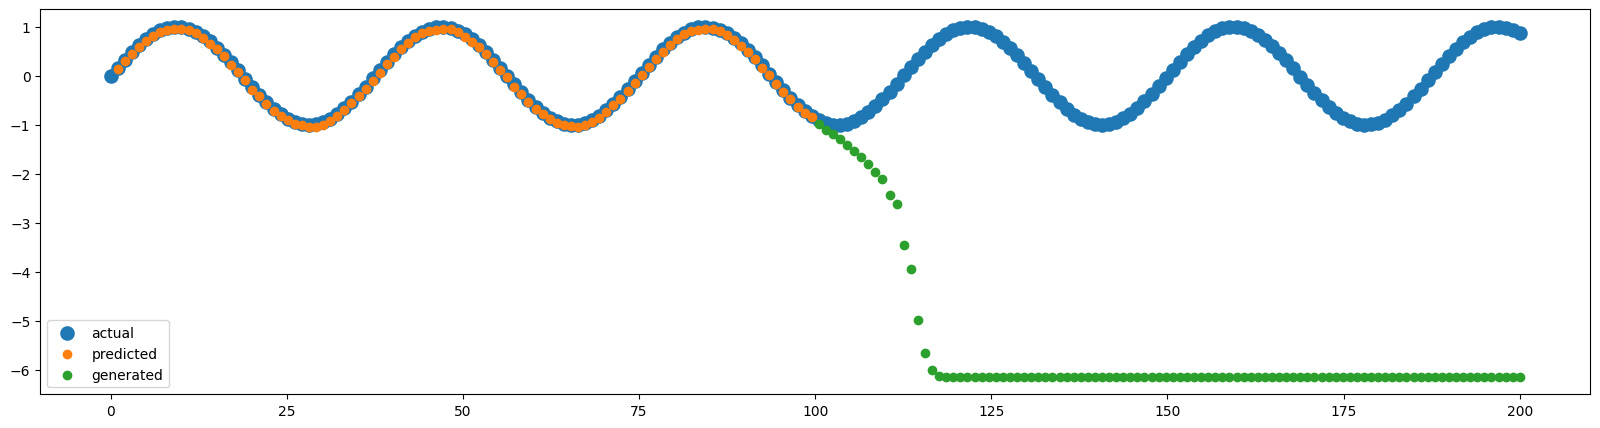

In [52]:
generated=[]
lastData = predictions[-1] #last Predictions From Training Data
inputX = torch.tensor(lastData).reshape(1,1,1)
hidden_state = hidden_prev


for i in range(numberOfTestingPoints):
    pred, hidden_state = model(inputX, hidden_state)
    generated.append(pred.item())
    inputX = pred

predictions = predictions+generated #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(timeLapse, SinosidualwaveData, s=90, label='actual')
plt.scatter(timeLapse[1:numberOftrainingPoints], predictions[:numberOftrainingPoints-1], label='predicted')
plt.scatter(timeLapse[numberOfTestingPoints:], predictions[numberOfTestingPoints-1:], label='generated')
ax.legend()

Answer to Starting Question<br>
ChatGPT falls under the category of generative learning. 